# Investigating the topics in SFA lyrics

Use Textacy to create a corpus of spaCy documents, and then peform NMF topic analysis.

In [6]:
import pandas as pd
import textacy
import spacy
import string
import re
from spacy.lang.en.stop_words import STOP_WORDS

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from spacy_pipeline_functions import remove_parts, remove_stopwords


from os import path
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load('en')
% matplotlib inline

Load the lyrics of all english language songs from a studio album. Also crteate a 'metadata' string - basiclly a string representation of json or dict that we will use later to identify each song as it is transformed into a spaCy doc.

In [7]:
lyrics = pd.read_csv("data/SFALyrics_p.csv", dtype=str)

#lyrics['lyrics'] = lyrics['lyrics'].replace('\n',' ', regex=True)
lyrics['lyrics'] = lyrics['lyrics'].str.lower()
lyrics['metadata'] = '{"title": "' + lyrics['title'] + '" ,"album":"' + lyrics['album'] + '"}'

lyrics.head()

,Unnamed: 0,lyrics,title,album,metadata
0,0,I had a soul transplant operation \nCoz my byp...,God! How me magic,Fuzzy Logic,"{""title"": ""God! How me magic"" ,""album"":""Fuzzy ..."
1,1,"[Bunf:] \nHamster, turnin' round in your wheel...",Fuzzy Birds,Fuzzy Logic,"{""title"": ""Fuzzy Birds"" ,""album"":""Fuzzy Logic""}"
2,2,"First time, I did it for the hell of it \nStuc...",Something 4 the weekend,Fuzzy Logic,"{""title"": ""Something 4 the weekend"" ,""album"":""..."
3,3,Locked in a sorry dream \nYou know we're drown...,Frisbee,Fuzzy Logic,"{""title"": ""Frisbee"" ,""album"":""Fuzzy Logic""}"
4,4,I was lost \nLost on the bypass road \nCould b...,Hometown Unicorm,Fuzzy Logic,"{""title"": ""Hometown Unicorm"" ,""album"":""Fuzzy L..."


## Pre-process text

In [8]:
nlp.pipeline

[('tagger', <spacy.pipeline.Tagger at 0x1a182fada0>),
 ('parser', <spacy.pipeline.DependencyParser at 0x1a2f2496d0>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x1a1834f258>)]

In [9]:
nlp.add_pipe(remove_parts, 'rm_parts',  after ='tagger')

In [10]:
nlp.pipeline

[('tagger', <spacy.pipeline.Tagger at 0x1a182fada0>),
 ('rm_parts',
  <function spacy_pipeline_functions.remove_parts(doc, stop=True, punct=True, space=True, num=True, digit=True, currency=True, url=True, email=True)>),
 ('parser', <spacy.pipeline.DependencyParser at 0x1a2f2496d0>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x1a1834f258>)]

Lets have a look customising the stopword list

In [11]:
nlp.vocab["be"].is_stop = True
nlp.vocab["are"].is_stop = True
nlp.vocab["go"].is_stop = True
nlp.vocab["will"].is_stop = True
nlp.vocab["\n"].is_stop = True
nlp.vocab["'re"].is_stop = True
nlp.vocab["n't"].is_stop = True
nlp.vocab["and"].is_stop = True
nlp.vocab[""].is_stop = True

Now, lets create a spaCy doument from each song lyric

In [12]:
lyrics['doc'] = lyrics['lyrics'].apply(nlp)
lyrics.head()

,Unnamed: 0,lyrics,title,album,metadata,doc
0,0,I had a soul transplant operation \nCoz my byp...,God! How me magic,Fuzzy Logic,"{""title"": ""God! How me magic"" ,""album"":""Fuzzy ...","(I, soul, transplant, operation, Coz, bypass, ..."
1,1,"[Bunf:] \nHamster, turnin' round in your wheel...",Fuzzy Birds,Fuzzy Logic,"{""title"": ""Fuzzy Birds"" ,""album"":""Fuzzy Logic""}","(Bunf, Hamster, turnin, round, wheel, I, 've, ..."
2,2,"First time, I did it for the hell of it \nStuc...",Something 4 the weekend,Fuzzy Logic,"{""title"": ""Something 4 the weekend"" ,""album"":""...","(First, time, I, hell, Stuck, tongue, And, swa..."
3,3,Locked in a sorry dream \nYou know we're drown...,Frisbee,Fuzzy Logic,"{""title"": ""Frisbee"" ,""album"":""Fuzzy Logic""}","(Locked, sorry, dream, You, know, drowning, de..."
4,4,I was lost \nLost on the bypass road \nCould b...,Hometown Unicorm,Fuzzy Logic,"{""title"": ""Hometown Unicorm"" ,""album"":""Fuzzy L...","(I, lost, Lost, bypass, road, Could, worse, I,..."


In [13]:
sents = list(lyrics['doc'][0].sents)
sents[0]

I soul transplant operation Coz bypass function

## Create a corpus
A corpus is an ordered collection of textacy Docs, all processed by the same spacy language pipeline. We can convert our dataframe of documents into a corpus, using our json string as metadata.

In [14]:
corpus = textacy.Corpus(nlp, docs=list(lyrics['doc']), metadatas= list(lyrics['metadata']))

In [15]:
print("This corpus has {} documents, {} sentances and {} tokens".format(corpus.n_docs, corpus.n_sents, corpus.n_tokens))

This corpus has 83 documents, 1485 sentances and 8715 tokens


### Usuing Corpus we can still access details about each doument
Each document is a song, so lets get the details from each, usuing the lyrics themselves and any metadata.
The metatdata is stored as a dict string - or json - so needs to be intepretted

In [16]:
import json
n = 45
doc = corpus[n]
d = json.loads(doc.metadata.replace("'", "\""))
ts = textacy.TextStats(doc)
print("{} from the album {} has {} unique words".format(d['title'], d['album'], ts.n_unique_words))

Liberty Belle from the album Phantom Power has 74 unique words


## Topic Analysis
We can vectorise and transform the corpus ready for further statitical models.

In [17]:
vectorizer = textacy.Vectorizer(
    tf_type='linear', apply_idf=True, idf_type='smooth', norm='l2',
    min_df=2, max_df=0.95)

In [18]:
doc_term_matrix = vectorizer.fit_transform(
    (doc.to_terms_list(ngrams=1, named_entities=True, as_strings=True)
        for doc in corpus))

print(repr(doc_term_matrix))

<83x577 sparse matrix of type '<class 'numpy.float64'>'
	with 2484 stored elements in Compressed Sparse Row format>


Lets apply a model to analyse the key topics in the corpus. Lets use NMF and assume 5 topics.

In [19]:
model = textacy.tm.TopicModel('nmf', n_topics=5)
model.fit(doc_term_matrix)
model

TopicModel(n_topics=5, model=NMF)

Lets view the top words that the model has found:

In [20]:
doc_topic_matrix = model.transform(doc_term_matrix)
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term):
    print('topic', topic_idx, ':', ', '.join(top_terms))
for i, val in enumerate(model.topic_weights(doc_topic_matrix)):
    print(i, val)

topic 0 : I, You, And, have, away, know, be, We, It, time
topic 1 : la, Long, go, La, school, gon, door, And, I, na
topic 2 : get, have, phone, She, spy, I, heart, fire, 'cos, lie
topic 3 : people, mountain, They, one, will, We, One, There, And, chance
topic 4 : Show, hand, God, jump, mad, be, Into, I, What, keep
0 0.5137531986839143
1 0.1267122130277577
2 0.1595504738765729
3 0.11660932841680724
4 0.08337478599494794


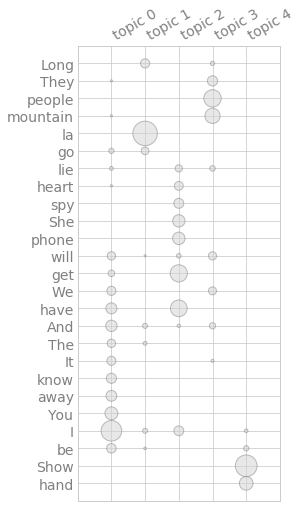

In [21]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term,
                   topics=-1,  n_terms=25, sort_terms_by='seriation')